In [1]:
from oemof import solph

import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("time_series.csv", index_col=0, parse_dates=True)

In [3]:
es = solph.EnergySystem(timeindex=df.index, infer_last_interval=False)

In [4]:
b_gas = solph.Bus("gas bus")
b_electricity = solph.Bus("electricity bus")
b_heat = solph.Bus("heat bus")

source_gas = solph.components.Source("gas grid import", outputs={b_gas: solph.Flow(variable_costs=df["gas_price"] + df["co2_price"])})
source_electricity = solph.components.Source("electricity grid import", outputs={b_electricity: solph.Flow(variable_costs=df["el_spot_price"])})
sink_heat = solph.components.Sink("heat demand", inputs={b_heat: solph.Flow(fix=df["heat"], nominal_value=1)})

heat_pump = solph.components.Converter(
    label="heat pump",
    inputs={b_electricity: solph.Flow()},
    outputs={b_heat: solph.Flow(nominal_value=100)},
    conversion_factors={b_heat: 3.5}
)
boiler = solph.components.Converter(
    label="gas boiler",
    inputs={b_gas: solph.Flow()},
    outputs={b_heat: solph.Flow(nominal_value=100)},
    conversion_factors={b_heat: 0.9}
)

heat_slack = solph.components.Source(
    label="heat slack",
    outputs={b_heat: solph.Flow(variable_costs=1000)}
)

storage = solph.components.GenericStorage(
    label="heat storage",
    inputs={b_heat: solph.Flow(nominal_value=50)},
    outputs={b_heat: solph.Flow(nominal_value=50)},
    nominal_storage_capacity=24 * 50
)

es.add(
    b_gas, b_electricity, b_heat,
    source_electricity, source_gas, sink_heat, heat_slack,
    heat_pump, boiler, storage
)

In [5]:
model = solph.Model(es)

_ = model.solve("gurobi")

results = solph.views.convert_keys_to_strings(model.results())

c:\Users\witt_fa\.conda\envs\tsam-oemof\Lib\site-packages\oemof\solph\_models.py:497: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if self.flows[o, i].fix[self.TIMESTEPS.at(1)] is not None:
c:\Users\witt_fa\.conda\envs\tsam-oemof\Lib\site-packages\oemof\solph\_models.py:500: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.flows[o, i].fix[t]
c:\Users\witt_fa\.conda\envs\tsam-oemof\Lib\site-packages\oemof\solph\flows\_simple_flow_block.py:464: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beha

In [6]:
total_cost_el = np.sum((
    results["electricity grid import", "electricity bus"]["sequences"]["flow"].values
    * df["el_spot_price"].values
)[:-1])

total_cost_gas = np.sum((
    results["gas grid import", "gas bus"]["sequences"]["flow"].values
    * (df["gas_price"].values + df["co2_price"].values)
)[:-1])

total_cost_slack = results["heat slack", "heat bus"]["sequences"]["flow"].sum() * 1000

total_heat_by_heat_pump = results["heat pump", "heat bus"]["sequences"]["flow"].sum()
total_heat_by_boiler = results["gas boiler", "heat bus"]["sequences"]["flow"].sum()
total_heat_by_slack = results["heat slack", "heat bus"]["sequences"]["flow"].sum()

<BarContainer object of 1 artists>

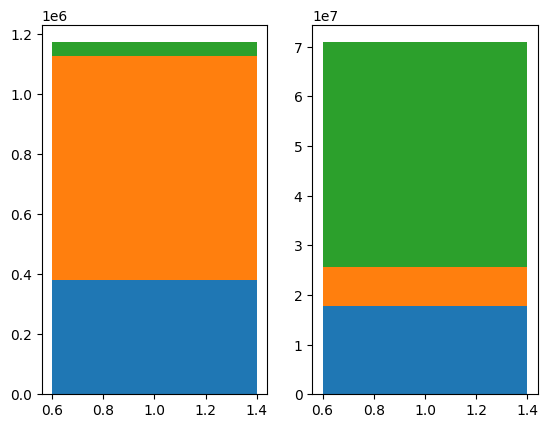

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

ax = ax.flatten()

ax[0].bar([1], [total_heat_by_boiler], bottom=0)
ax[0].bar([1], [total_heat_by_heat_pump], bottom=total_heat_by_boiler)
ax[0].bar([1], [total_heat_by_slack], bottom=total_heat_by_boiler + total_heat_by_heat_pump)

ax[1].bar([1], [total_cost_gas])
ax[1].bar([1], [total_cost_el], bottom=total_cost_gas)
ax[1].bar([1], [total_cost_slack], bottom=total_cost_el + total_cost_gas)